Original shape: (5110, 12)

Columns and dtypes:
 id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

After preprocessing shape: (5110, 11)
   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   


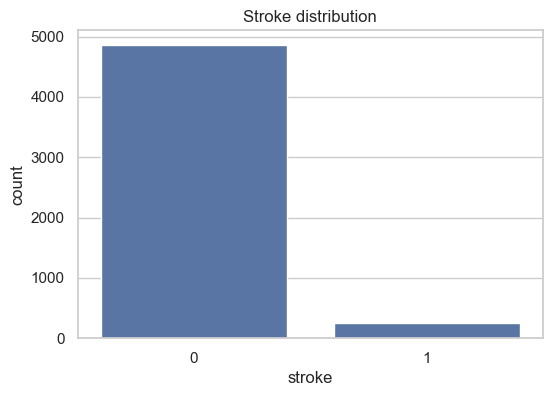

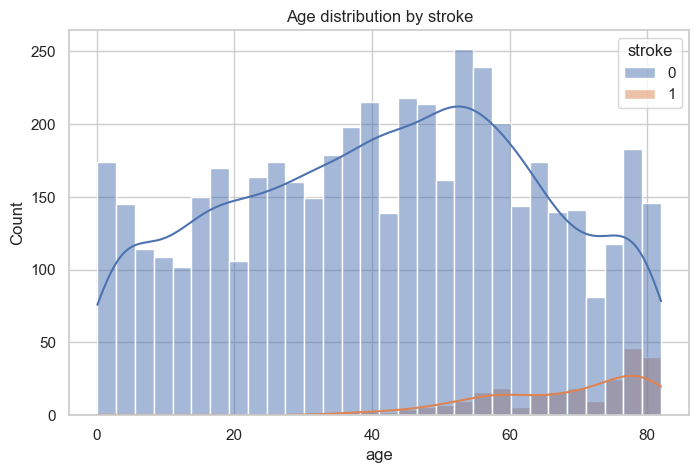

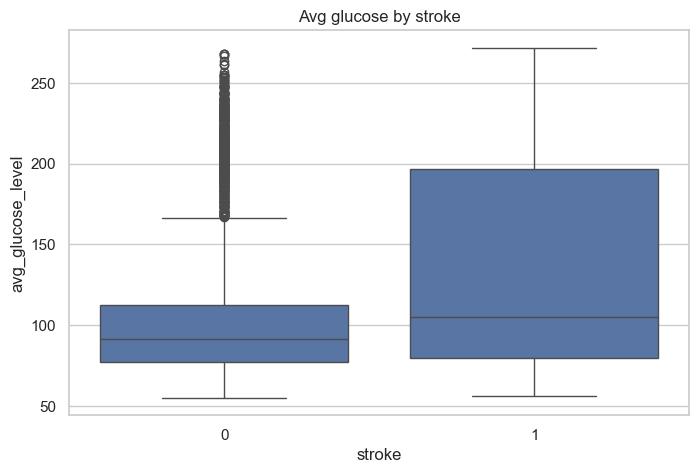

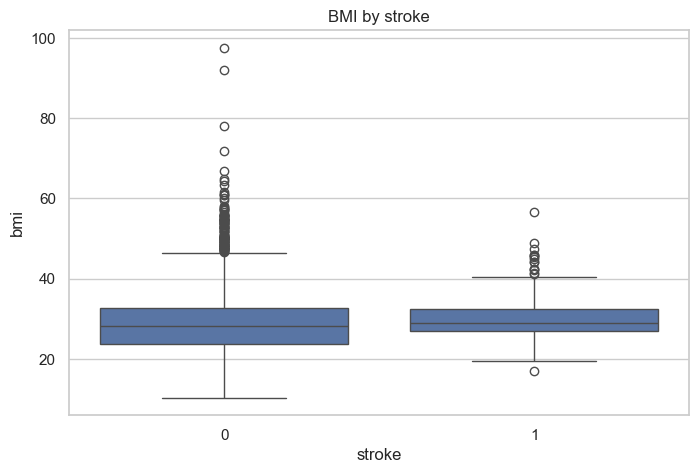

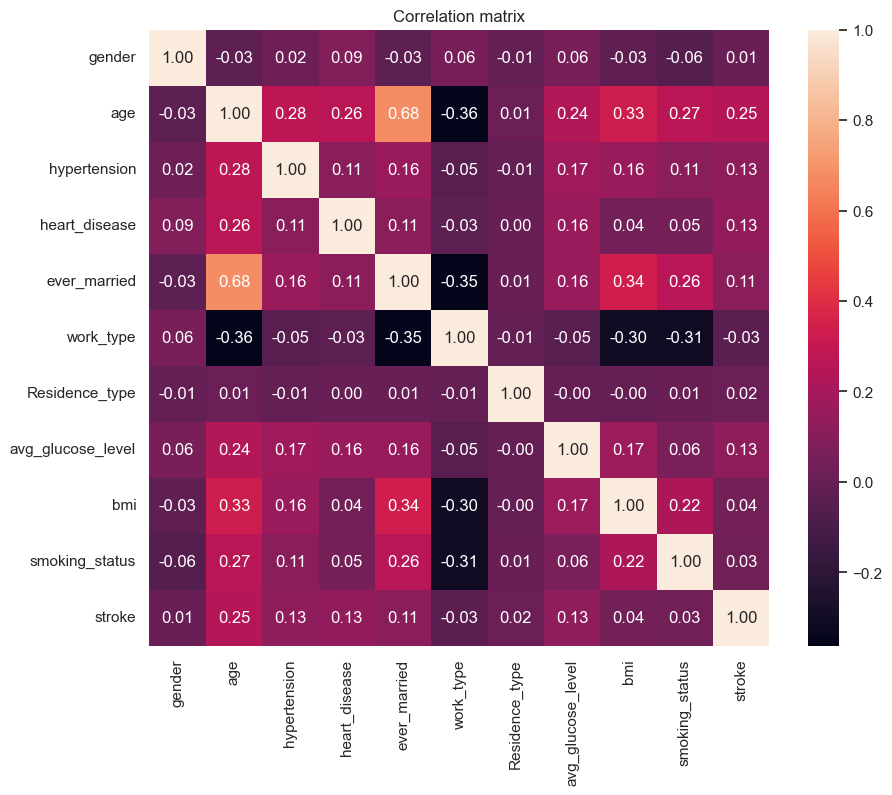


Train shape: (4088, 10) Test shape: (1022, 10)
Train stroke distribution:
 [0.95132094 0.04867906]
After SMOTE, counts: [3889 3889]

=== Logistic Regression ===
Accuracy: 0.7857142857142857
Precision: 0.14937759336099585
Recall: 0.72
F1: 0.24742268041237114

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.88       972
           1       0.15      0.72      0.25        50

    accuracy                           0.79      1022
   macro avg       0.57      0.75      0.56      1022
weighted avg       0.94      0.79      0.84      1022

Confusion Matrix:
 [[767 205]
 [ 14  36]]
ROC-AUC: 0.7862962962962963

=== Random Forest ===
Accuracy: 0.9031311154598826
Precision: 0.14492753623188406
Recall: 0.2
F1: 0.16806722689075632

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.14      0.20      0.17        50

    accurac

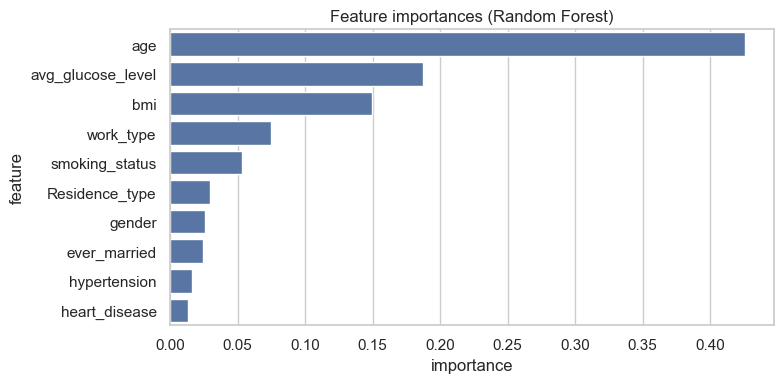

Saved Random Forest model to best_model_rf.joblib
Power BI CSVs generated: powerbi_age_summary.csv, powerbi_work_summary.csv, powerbi_smoking_summary.csv
Example predictions (first 5 test rows): [0 0 0 0 0] [0.05  0.08  0.09  0.095 0.06 ]

Artifacts: {'cleaned_csv': 'stroke_cleaned.csv', 'cleaned_model': 'best_model_rf.joblib', 'scaler': 'scaler.joblib', 'feature_importances': 'feature_importances.csv', 'plots': ['plot_stroke_distribution.png', 'plot_age_vs_stroke.png', 'plot_glucose_boxplot.png', 'plot_bmi_boxplot.png', 'plot_correlation_heatmap.png', 'plot_feature_importances.png'], 'powerbi_csvs': ['powerbi_age_summary.csv', 'powerbi_work_summary.csv', 'powerbi_smoking_summary.csv']}


In [4]:
# Full Stroke Prediction Project Notebook
# Save as: stroke_project_notebook.ipynb
# Assumes file "healthcare-dataset-stroke-data.csv" exists in working dir

# 0. Install optional dependencies if running locally (uncomment to use)
# !pip install imbalanced-learn
# !pip install matplotlib seaborn scikit-learn pandas numpy joblib

import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import joblib

# -------------------------
# 1. Load dataset
# -------------------------
DATA_PATH = "healthcare-dataset-stroke-data.csv"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)
df.head()

# -------------------------
# 2. Quick overview
# -------------------------
print("\nColumns and dtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# -------------------------
# 3. Preprocessing
# -------------------------
# Drop 'id' as it's not useful for modeling
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Basic clean: fill missing BMI with mean (you can also try median)
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# Trim whitespace from string columns (if any)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip()

# Encode categorical columns — use LabelEncoder for simplicity (you can use OneHot for non-ordinal)
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Cast types
df['stroke'] = df['stroke'].astype(int)

print("\nAfter preprocessing shape:", df.shape)
print(df.head())

# -------------------------
# 4. Save cleaned dataset for Power BI or downstream use
# -------------------------
CLEAN_CSV = "stroke_cleaned.csv"
df.to_csv(CLEAN_CSV, index=False)
print(f"\nSaved cleaned dataset to {CLEAN_CSV}")

# -------------------------
# 5. Exploratory Data Analysis (plots) - show & save
# -------------------------
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x='stroke', data=df)
plt.title("Stroke distribution")
plt.savefig("plot_stroke_distribution.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df, x='age', hue='stroke', bins=30, kde=True)
plt.title("Age distribution by stroke")
plt.savefig("plot_age_vs_stroke.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
plt.title("Avg glucose by stroke")
plt.savefig("plot_glucose_boxplot.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title("BMI by stroke")
plt.savefig("plot_bmi_boxplot.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Correlation matrix")
plt.savefig("plot_correlation_heatmap.png", bbox_inches='tight')
plt.show()

# -------------------------
# 6. Prepare features and target
# -------------------------
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split (stratify due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train stroke distribution:\n", np.bincount(y_train) / len(y_train))

# -------------------------
# 7. Handle class imbalance
# -------------------------
use_smote = False
try:
    from imblearn.over_sampling import SMOTE
    use_smote = True
except Exception as e:
    print("imblearn not available — will use class_weight where possible. Install via 'pip install imbalanced-learn' to use SMOTE.")

if use_smote:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE, counts:", np.bincount(y_train_res))
else:
    # fallback: use original training set and supply class_weight="balanced" to classifiers that support it
    X_train_res, y_train_res = X_train.copy(), y_train.copy()

# -------------------------
# 8. Scaling numeric features (only for models that need it)
# -------------------------
num_cols = ['age', 'avg_glucose_level', 'bmi']  # numeric features
scaler = StandardScaler()
X_train_scaled = X_train_res.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Save scaler
joblib.dump(scaler, "scaler.joblib")

# -------------------------
# 9. Model training & evaluation helpers
# -------------------------
def evaluate_model(model, X_t, y_t, X_v, y_v, name="Model"):
    y_pred = model.predict(X_v)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_v)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_v)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_v, y_pred))
    print("Precision:", precision_score(y_v, y_pred, zero_division=0))
    print("Recall:", recall_score(y_v, y_pred, zero_division=0))
    print("F1:", f1_score(y_v, y_pred, zero_division=0))
    print("\nClassification Report:\n", classification_report(y_v, y_pred, zero_division=0))
    cm = confusion_matrix(y_v, y_pred)
    print("Confusion Matrix:\n", cm)
    if y_proba is not None:
        try:
            roc = roc_auc_score(y_v, y_proba)
            print("ROC-AUC:", roc)
        except:
            pass

# -------------------------
# 10. Train multiple models
# -------------------------
models = {}

# Logistic Regression (with class_weight fallback)
lr = LogisticRegression(max_iter=1000, class_weight='balanced' if not use_smote else None, random_state=42)
lr.fit(X_train_scaled, y_train_res)
evaluate_model(lr, X_train_scaled, y_train_res, X_test_scaled, y_test, "Logistic Regression")
models['logistic'] = lr

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced' if not use_smote else None)
rf.fit(X_train_res, y_train_res)
evaluate_model(rf, X_train_res, y_train_res, X_test, y_test, "Random Forest")
models['rf'] = rf

# Decision Tree
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced' if not use_smote else None)
dt.fit(X_train_res, y_train_res)
evaluate_model(dt, X_train_res, y_train_res, X_test, y_test, "Decision Tree")
models['dt'] = dt

# KNN (doesn't support class_weight; scaling used)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_res)
evaluate_model(knn, X_train_scaled, y_train_res, X_test_scaled, y_test, "KNN")
models['knn'] = knn

# -------------------------
# 11. Feature importance (using Random Forest)
# -------------------------
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nFeature importances:\n", feat_imp)
feat_imp.to_csv("feature_importances.csv", index=False)

plt.figure(figsize=(8,4))
sns.barplot(data=feat_imp, x='importance', y='feature')
plt.title("Feature importances (Random Forest)")
plt.tight_layout()
plt.savefig("plot_feature_importances.png")
plt.show()

# -------------------------
# 12. Save best model (choose RF here, but you can change)
# -------------------------
BEST_MODEL_PATH = "best_model_rf.joblib"
joblib.dump(rf, BEST_MODEL_PATH)
print(f"Saved Random Forest model to {BEST_MODEL_PATH}")

# -------------------------
# 13. Create aggregated tables for Power BI dashboard
# -------------------------
agg_by_age = df.copy()
agg_by_age['age_group'] = pd.cut(agg_by_age['age'], bins=[0,18,30,45,55,65,100],
                                 labels=['0-18','19-30','31-45','46-55','56-65','66+'])
age_summary = agg_by_age.groupby('age_group').agg(
    total=('stroke','count'),
    stroke_count=('stroke','sum'),
    stroke_rate=('stroke', lambda x: x.sum()/x.count())
).reset_index()
age_summary.to_csv("powerbi_age_summary.csv", index=False)

# By work_type
work_summary = df.groupby('work_type').agg(
    total=('stroke','count'),
    stroke_count=('stroke','sum'),
    stroke_rate=('stroke', lambda x: x.sum()/x.count()),
    avg_glucose=('avg_glucose_level','mean'),
    avg_bmi=('bmi','mean')
).reset_index()
work_summary.to_csv("powerbi_work_summary.csv", index=False)

# By smoking status
smoke_summary = df.groupby('smoking_status').agg(
    total=('stroke','count'),
    stroke_count=('stroke','sum'),
    stroke_rate=('stroke', lambda x: x.sum()/x.count())
).reset_index()
smoke_summary.to_csv("powerbi_smoking_summary.csv", index=False)

# Full cleaned dataset already saved as stroke_cleaned.csv
print("Power BI CSVs generated: powerbi_age_summary.csv, powerbi_work_summary.csv, powerbi_smoking_summary.csv")

# -------------------------
# 14. Example: function to predict on new samples
# -------------------------
def predict_sample(sample_df):
    """
    sample_df: pandas DataFrame with same columns as X (gender, age, hypertension, heart_disease,
    ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status)
    Returns: predicted label and probability (if available)
    """
    s = sample_df.copy()
    s[num_cols] = scaler.transform(s[num_cols])
    model = joblib.load(BEST_MODEL_PATH)
    label = model.predict(s)
    prob = None
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(s)[:,1]
    return label, prob

# Example usage:
sample = X_test.head(5).copy()
pred_label, pred_prob = predict_sample(sample)
print("Example predictions (first 5 test rows):", pred_label, pred_prob)

# -------------------------
# 15. Save notebook artifacts list
# -------------------------
artifacts = {
    "cleaned_csv": CLEAN_CSV,
    "cleaned_model": BEST_MODEL_PATH,
    "scaler": "scaler.joblib",
    "feature_importances": "feature_importances.csv",
    "plots": [
        "plot_stroke_distribution.png",
        "plot_age_vs_stroke.png",
        "plot_glucose_boxplot.png",
        "plot_bmi_boxplot.png",
        "plot_correlation_heatmap.png",
        "plot_feature_importances.png"
    ],
    "powerbi_csvs": [
        "powerbi_age_summary.csv",
        "powerbi_work_summary.csv",
        "powerbi_smoking_summary.csv"
    ]
}
print("\nArtifacts:", artifacts)
